# Лабораторная работа 5  
## Тактовая синхронизация
Выполнила: Шаповалова Виктория, ИКТ-11М.  

### 1. Импорт библиотек  
В данном разделе импортируются библиотеки, которые будут использоваться в ходе выполнения работы.

In [81]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift
from scipy.signal import spectrogram
from scipy import signal
import math

### 2. Задание параметров  
В данном разделе задаются параметры, которые будут использованы в ходе выполнения работы.

In [82]:
random.seed(41)
fs = 1e6
data_len = 128
sps = 8
num_taps = 101
beta = 0.35
delay = 2 
N = 21
snr = 10
span = 10
alpha = 0.35 # Параметр сглаживания RRC
intrp = 8

### 3. Схема модели  
На рисунке представлена схема, реализуемой системы, состоящей из приемника и передатчика.  
На передающей стороне сигнал создается генератором случайного сигнала, затем производится маппинг битов на символы. После чего производится повышающая интерполяция сигнала и проход его через фильтр формирования импульсов. Далее сигнал отправляется в канал, где на него накладывается АБГШ. На приемной стороне сигнал в первую очередь проходит через согласованный фильтр формирования импульсов, затем корректируется блоком тактовой синхронизации с одновременной понижающей интерполяцией сигнала, откуда сигнал отправляется на блок принятия решений и дальнейший демаппинг символов в биты.  
В ходе лабораторной работы будут реализованы все перечисленные блоки системы.

![lab5_2.drawio.svg](lab5_2.drawio.svg)

### 4. Генерация случайного сигнала, маппинг, интерполяция  
В данном разделе с помощью функции рандома генерируется информационный сигнал длины data_len, затем производится маппинг битов на символы BPSK и апсемплинг.

c:\Users\Victoria\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Victoria\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\ma\core.py:3448: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
c:\Users\Victoria\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Амплитуда')

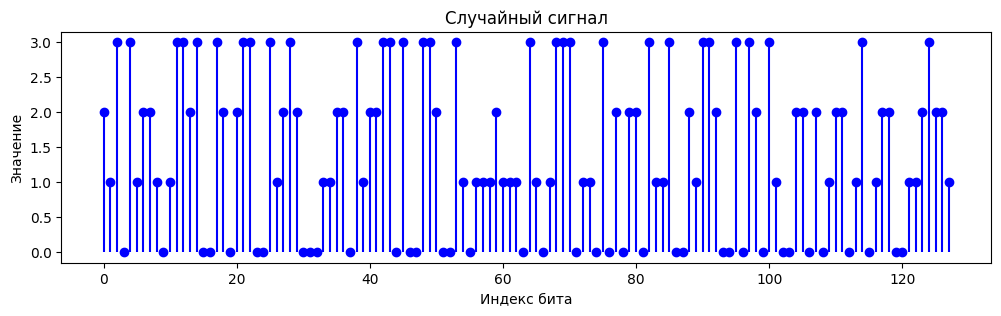

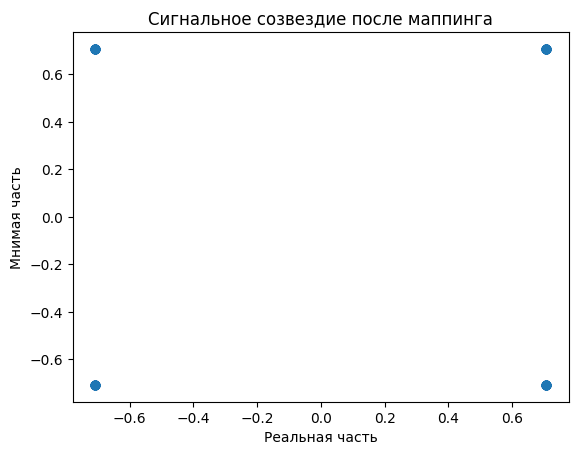

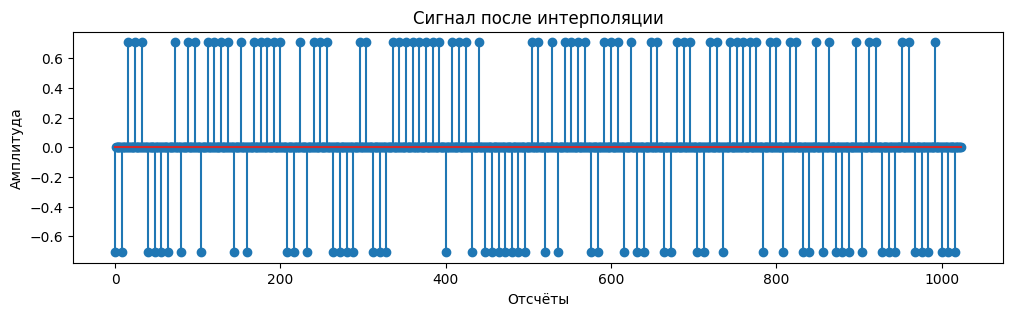

In [83]:
# Генерация случайных битов
bits = np.random.randint(0, 4, data_len)

# Маппинг битов в символы
#symbols = 2*bits - 1   
symbols = np.exp(1j*(np.pi/2*bits + np.pi/4))

# Повышающая интерполяция (upsampling)
upsampled = np.zeros(len(symbols) * sps, dtype=complex)
upsampled[0::sps] = symbols  

fig, ax = plt.subplots(1,figsize=(12,3))
plt.stem(bits, linefmt='b-', markerfmt='bo', basefmt=' ')
plt.title(f'Случайный сигнал')
plt.xlabel("Индекс бита")
plt.ylabel("Значение")

plt.figure(3)
plt.scatter(np.real(symbols), np.imag(symbols))
plt.title(f'Сигнальное созвездие после маппинга')
plt.ylabel("Мнимая часть")
plt.xlabel("Реальная часть")

fig, ax = plt.subplots(1,figsize=(12,3))
plt.stem(upsampled)
plt.title(f'Сигнал после интерполяции')
plt.xlabel("Отсчёты")
plt.ylabel("Амплитуда")

### 5. Фильтр формирования импульса  
В качестве формирующего фильтра был использован фильтр корня из приподнятого косинуса. В данном разделе описана функция для генерации импульсной характеристики rrc-фильтра, а также непосредственно свертка сигнала с импульсной характеристикой фильтра. Параметр сглаживания, регулирующим полосу пропускания, задан равным 0,35.  
На первом графике представлена частотная характеристика фильтра. Как видно, он является полосно-пропускающим.   
На втором графике показан сигнал, прошедший через фильтр приподнятого косинуса: резкие импульсы сгладились, что позволяет бороться с межсимвольной интерференцией в канале.

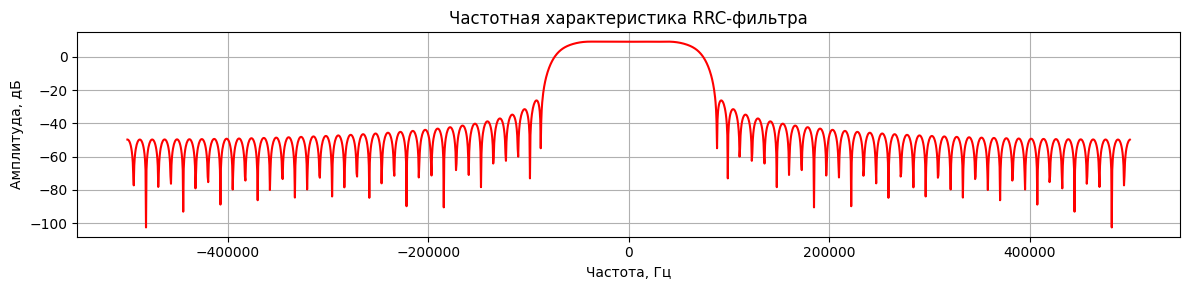

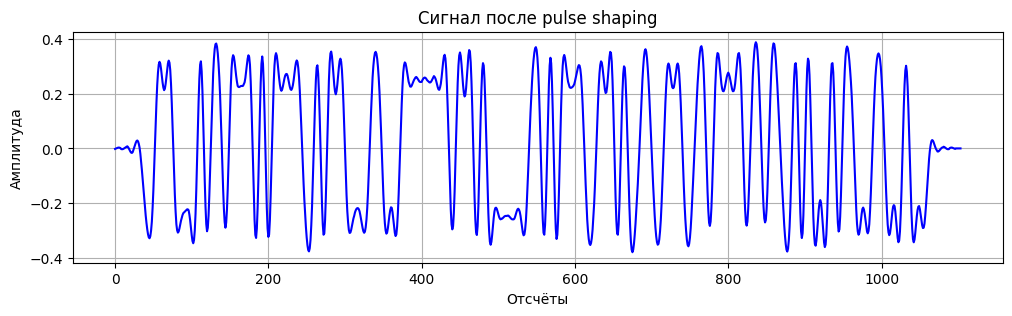

In [84]:
def rrc_filt(span, sps, alpha):
    t = np.arange(-span*sps/2, span*sps/2 + 1) / sps
    h_rrc = np.zeros_like(t)
    for i, ti in enumerate(t):
        if ti == 0:
            h_rrc[i] = (1 - alpha + 4*alpha/np.pi)
        elif abs(ti) == 1/(4*alpha):
            h_rrc[i] = alpha/np.sqrt(2)*((1+2/np.pi)*np.sin(np.pi/(4*alpha)) + (1-2/np.pi)*np.cos(np.pi/(4*alpha)))
        else:
            num = np.sin(np.pi*ti*(1-alpha)) + 4*alpha*ti*np.cos(np.pi*ti*(1+alpha))
            den = np.pi*ti*(1-(4*alpha*ti)**2)
            h_rrc[i] = num / den
    h_rrc /= np.sqrt(sps)
    return(h_rrc)
h_rrc = rrc_filt(span, sps, alpha)
tx = np.convolve(upsampled, h_rrc)

H = fftshift(fft(h_rrc, 2048))
f = np.linspace(-fs/2, fs/2, len(H))
plt.figure(figsize=(12, 3))
plt.plot(f, 20*np.log10(np.abs(H)), 'r-')
plt.title("Частотная характеристика RRC-фильтра")
plt.xlabel("Частота, Гц")
plt.ylabel("Амплитуда, дБ")
plt.grid()
plt.tight_layout()
plt.show()

# Визуализация временной области
plt.figure(figsize=(12, 3))
plt.plot(tx, 'b-')
plt.title("Сигнал после pulse shaping")
plt.xlabel("Отсчёты")
plt.ylabel("Амплитуда")
plt.grid()
plt.show()


### 6. Добавление задержки
Чтобы реализовать задержку, в данном разделе применялся оконный фильтр (окно Хэмминга). На графике показано временное представление сигнала на выходе передатчика и его сдвинутую на 2 отсчета копию.

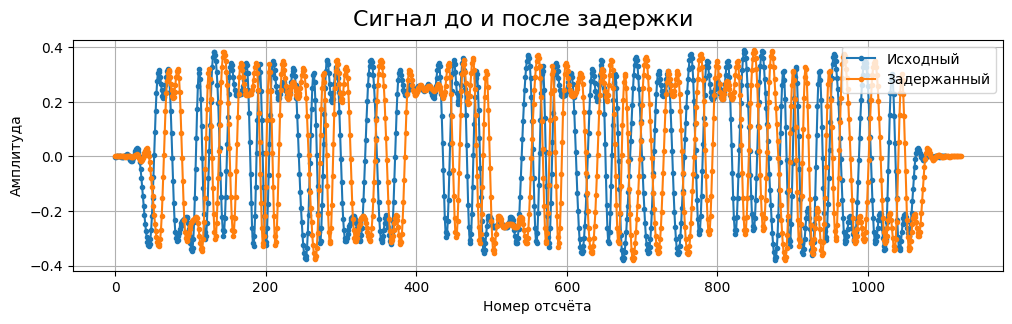

In [85]:
# Фильтр задержки
n = np.arange(-N//2, N//2) # ...-3,-2,-1,0,1,2,3...
h = np.sinc(n - delay)
h *= np.hamming(N) # использование окна Хэмминга для фильтра
h /= np.sum(h) # нормализация, чтобы получить единичный коэффициент усиления и не изменять амплитуду/мощность

fig, ax = plt.subplots(1,figsize=(12,3))
fig.suptitle("Сигнал до и после задержки", fontsize=16)
plt.plot(tx, '.-', label = 'Исходный')

tx_shift = np.convolve(tx, h) # применение фильтра

plt.plot(tx_shift, '.-', label = 'Задержанный')
ax.legend()
plt.grid()
plt.xlabel("Номер отсчёта")
plt.ylabel("Амплитуда")
plt.show()

### 7. Добавление АБГШ 
К сдвинутому сигналу добавляется АБГШ, который создается функцией awgn. Входным параметром задается отношение сигнал/шум в дБ. В данном примере оно задано 10 дБ. 

Text(0, 0.5, 'Амплитуда')

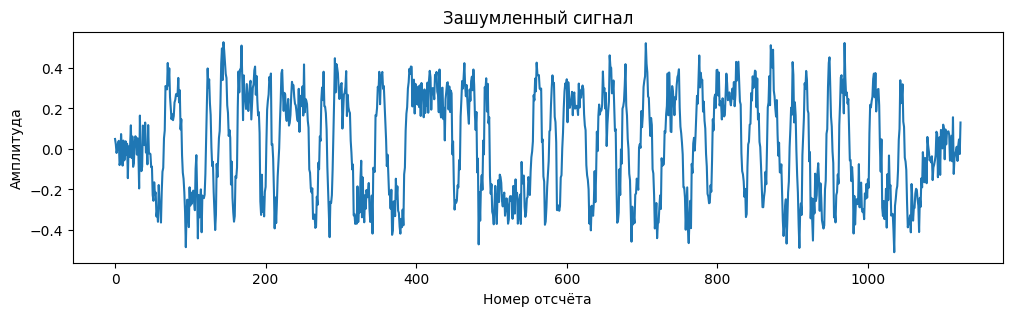

In [86]:
def awgn(signal, snr):
    sig_power = np.mean(np.abs(signal)**2) # calculate signal power
    sig_power_db = 10* np.log10(sig_power) # convert to dB

    noise_power_db = sig_power_db - snr
    noise_power = 10**(noise_power_db / 10)

    complex_noise = np.sqrt(noise_power/2)*(np.random.randn(len(signal)) + \
                                            np.random.randn(len(signal))*1j)

    return complex_noise


awgn_noise = awgn(tx_shift, snr)
tx_noisy = tx_shift + awgn_noise

fig, ax = plt.subplots(1,figsize=(12,3))
plt.plot(tx_noisy)
plt.title('Зашумленный сигнал')
plt.xlabel("Номер отсчёта")
plt.ylabel("Амплитуда")

### 8. Приемная часть
На приемной стороне находится такой же фильтр корня из приподнятого косинуса, что и на передаче. Как видно на графике, сигнал получается сглаженным относительно пришедшего сигнала, но имеет ошибки, внесенные шумом.

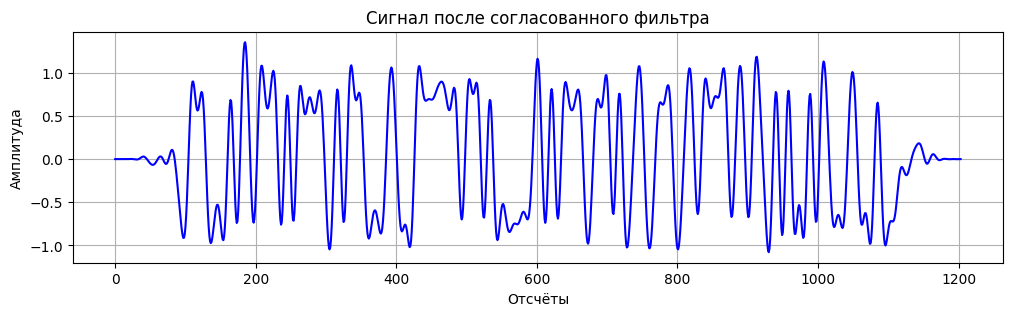

In [87]:
rx = np.convolve(tx_noisy, h_rrc)

# Визуализация временной области
plt.figure(figsize=(12, 3))
plt.plot(rx, 'b-')
plt.title("Сигнал после согласованного фильтра")
plt.xlabel("Отсчёты")
plt.ylabel("Амплитуда")
plt.grid()
plt.show()

### 9. Тактовая синхронизация  
Далее реализована тактовая синхронизация для компенсации внесенной задержки. Большинство методов тактовой синхронизации имеют форму контура фазовой автоподстройки (PLL). ФАПЧ - это замкнутые системы, которые используют обратную связь для постоянной настройки чего-либо; в данном случае временной сдвиг позволяет производить выборку на пике цифровых символов. Блок синхронизации действует как “дециматор”, т.е.выборка на выходе будет составлять долю от количества отсчетов.   
Как правило, разница между методами синхронизации, основанными на ФАПЧ, заключается в уравнении, используемом для выполнения коррекции смещения синхронизации. Значение *mu* обновляется на каждой итерации цикла. Если *mu* = 3,61 отсчет, то это означает, что требуется сместить входные данные на 3,61 отсчета, чтобы выполнить выборку в нужном месте. В сучае если значение *mu* превысит установленное отсчетов на символ, то оно просто вернется к нулю.

Далее будет применен метод синхронизации Mueller и Muller (схема Мюллера-Мюллера). 
На графике представлен результат работы схемы. Даунсемплинг сразу включен в схему. На график также добавлен исходный сигнал. В результате сравнения видно, что схеме требуется некоторое время на синхронизацию, однако потом последовательности совпадают.

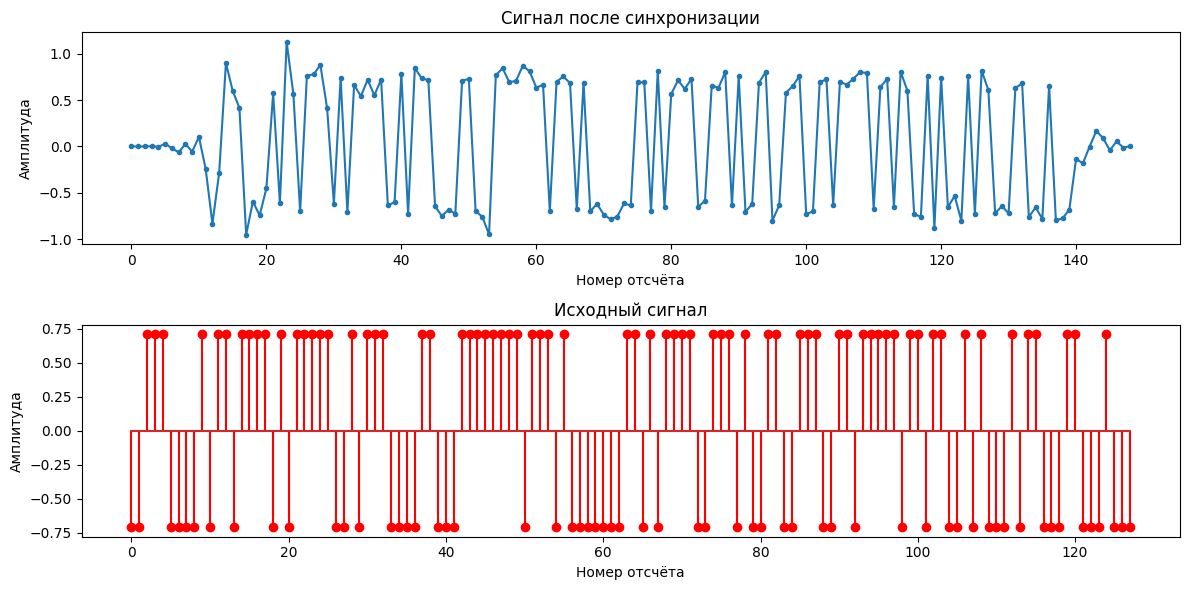

In [88]:
def syncMM(rx, sps):
    mu = 0 # initial estimate of phase of sample
    out = np.zeros(len(rx) + 10, dtype=np.complex64)
    out_rail = np.zeros(len(rx) + 10, dtype=np.complex64) # stores values, each iteration we need the previous 2 values plus current value
    i_in = 0 # input samples index
    i_out = 2 # output index (let first two outputs be 0)
    while i_out < len(rx) and i_in + 16 < len(rx):
        out[i_out] = rx[i_in] # grab what we think is the "best" sample
        out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
        x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
        y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
        mm_val = np.real(y - x)
        mu += sps + 0.3*mm_val
        i_in += int(np.floor(mu)) # round down to nearest int since we are using it as an index
        mu = mu - np.floor(mu) # remove the integer part of mu
        i_out += 1 # increment output index
    out = out[2:i_out] # remove the first two, and anything after i_out (that was never filled out)
    return(out)

rx_sync = syncMM(rx, sps)

fig, ((ax1, ax2)) = plt.subplots(2,1, figsize = (12,6))

ax1.title.set_text('Сигнал после синхронизации')
ax1.plot(rx_sync, '.-')
ax1.set_xlabel("Номер отсчёта")
ax1.set_ylabel("Амплитуда")


ax2.title.set_text('Исходный сигнал')
ax2.stem(symbols, 'r')
ax2.set_xlabel("Номер отсчёта")
ax2.set_ylabel("Амплитуда")

plt.tight_layout()
plt.show()

Теперь внесена дробная задержка и также оценены результаты. По графикам видно, что синхронизация справляется уже не так хорошо как раньше.

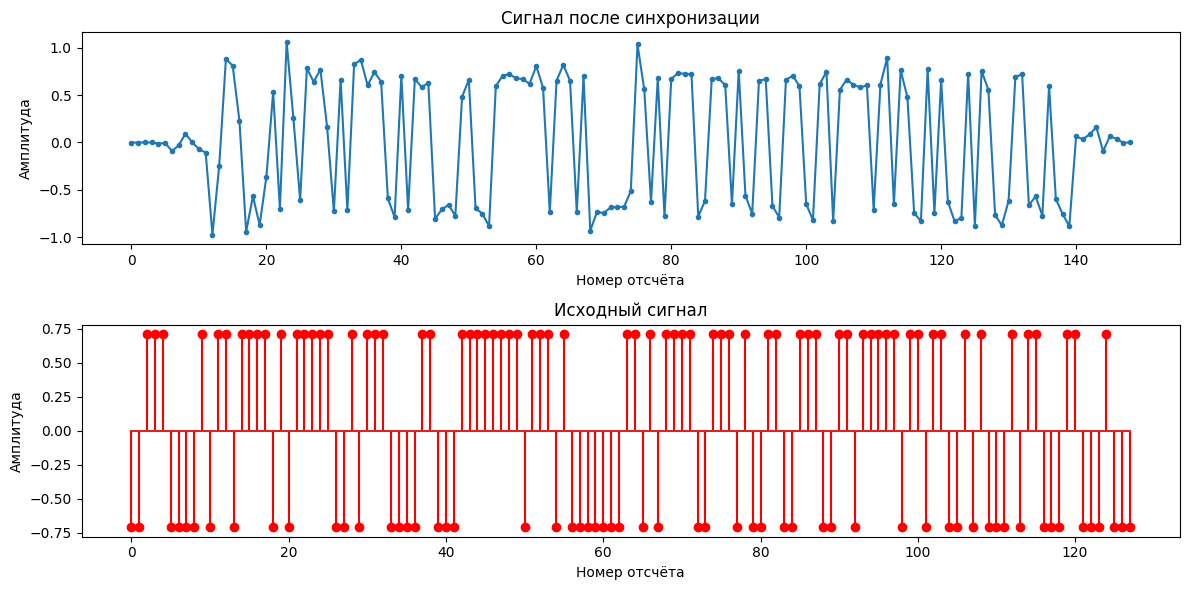

In [89]:
delay = 1.4
n = np.arange(-N//2, N//2) # ...-3,-2,-1,0,1,2,3...
h = np.sinc(n - delay)
h *= np.hamming(N) # использование окна Хэмминга для фильтра
h /= np.sum(h)
tx_shift = np.convolve(tx, h) # применение фильтра
awgn_noise = awgn(tx_shift, snr)
tx_noisy = tx_shift + awgn_noise
rx = np.convolve(tx_noisy, h_rrc)
rx_sync = syncMM(rx, sps)

fig, ((ax1, ax2)) = plt.subplots(2,1, figsize = (12,6))

ax1.title.set_text('Сигнал после синхронизации')
ax1.plot(rx_sync, '.-')
ax1.set_xlabel("Номер отсчёта")
ax1.set_ylabel("Амплитуда")


ax2.title.set_text('Исходный сигнал')
ax2.stem(symbols, 'r')
ax2.set_xlabel("Номер отсчёта")
ax2.set_ylabel("Амплитуда")

plt.tight_layout()
plt.show()

При синхронизации к входным отсчетам часто применяется интерполяция для компенсации дробной временной задержки. В данном случае применена синхронизация с интерполяцией 8. По графикам видно, что результаты синхронизации с интерполяцией и без имеют некоторые различия - сигнал с интерполяцией имеет меньший разброс амплитуд. Также на график добавлены результаты для случая после даунсемплинга без синхронизации. Сравнение показывает, что этот случай наименее похож на исходные импульсы.

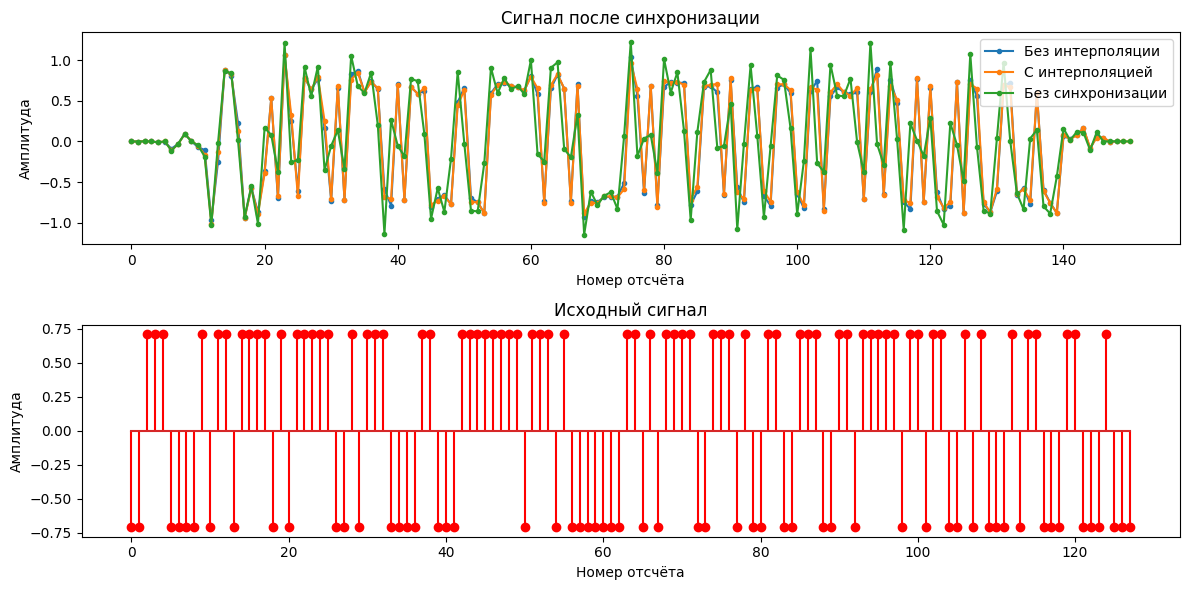

In [90]:
rx_intrp = signal.resample_poly(rx, intrp, 1)

def syncMM(rx, sps, rx_intrp, intrp):
    mu = 0 # initial estimate of phase of sample
    out = np.zeros(len(rx) + 10, dtype=np.complex64)
    out_rail = np.zeros(len(rx) + 10, dtype=np.complex64) # stores values, each iteration we need the previous 2 values plus current value
    i_in = 0 # input samples index
    i_out = 2 # output index (let first two outputs be 0)
    while i_out < len(rx) and i_in < len(rx):
        out[i_out] = rx_intrp[i_in*intrp + int(mu*intrp)] # grab what we think is the "best" sample
        out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
        x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
        y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
        mm_val = np.real(y - x)
        mu += sps + 0.3*mm_val
        i_in += int(np.floor(mu)) # round down to nearest int since we are using it as an index
        mu = mu - np.floor(mu) # remove the integer part of mu
        i_out += 1 # increment output index
    out = out[2:i_out] # remove the first two, and anything after i_out (that was never filled out)
    return(out)

rx_sync_intrp = syncMM(rx, sps, rx_intrp, intrp)

def downsample(signal, sps):
    y = np.zeros(len(signal)//sps, dtype=complex)
    y = signal[0::sps]
    return y

rx_dwnsmp = downsample(rx, sps) 


fig, ((ax1, ax2)) = plt.subplots(2,1, figsize = (12,6))

ax1.title.set_text('Сигнал после синхронизации')
ax1.plot(rx_sync, '.-', label = 'Без интерполяции')
ax1.plot(rx_sync_intrp, '.-', label = 'С интерполяцией')
ax1.plot(rx_dwnsmp, '.-', label = 'Без синхронизации')
ax1.legend()
ax1.set_xlabel("Номер отсчёта")
ax1.set_ylabel("Амплитуда")


ax2.title.set_text('Исходный сигнал')
ax2.stem(symbols, 'r')
ax2.set_xlabel("Номер отсчёта")
ax2.set_ylabel("Амплитуда")

plt.tight_layout()
plt.show()

### 10. Принятие решений и демаппинг  
Далее производится принятие решений о символах с последующим переводом из символов в биты для случаев с синхронизацией и без нее. Принятие решений производится путем определения наиближайшей исходной точки к текущей точке.

In [91]:
#constellation = [-1, 1]
#decisions_intrp = np.array([constellation[np.argmin(np.abs(s - constellation))] for s in rx_sync_intrp])
#received_bits_intrp = (decisions_intrp > 0).astype(int)

#decisions = np.array([constellation[np.argmin(np.abs(s - constellation))] for s in rx_sync])
#received_bits = (decisions > 0).astype(int)

#decisions_dwnsmp = np.array([constellation[np.argmin(np.abs(s - constellation))] for s in rx_dwnsmp])
#received_bits_dwnsmp = (decisions_dwnsmp > 0).astype(int)

def qpsk_demod(signal_input):
    result = np.zeros((len(signal_input), 1), dtype=complex)
    point = np.arange(0, 4)
    ref_point = np.exp(1j*(np.pi/2.*point + np.pi/4))
    for i in np.arange(0, len(signal_input)):
        distance = np.abs(signal_input[i] - ref_point)
        ind_min = np.argmin(distance)
        result[i] = ref_point[ind_min]
    return result
    
decisions_intrp = qpsk_demod(rx_sync_intrp)
decisions = qpsk_demod(rx_sync)
decisions_dwnsmp = qpsk_demod(rx_dwnsmp)

### 11. Оценка результатов
В первую очередь результат работы схемы сравнен по сигнальному созвездию с передаваемым сигналом. Несмотря на влияние шума, созвездия на передаче и после отработки схемы совпадают, поэтому система принята работающей корректно. Появление точек в нулевой координате связано с работой фильтра. 

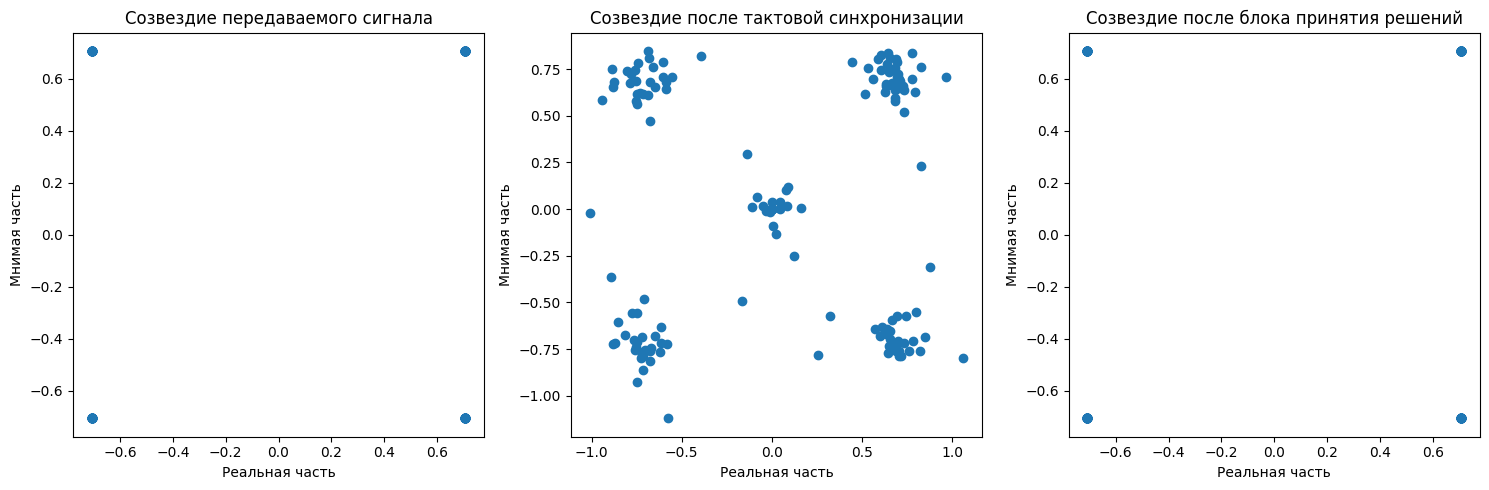

In [92]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize = (15,5))

ax1.title.set_text('Созвездие передаваемого сигнала')
ax1.scatter(np.real(symbols), np.imag(symbols))
ax1.set_xlabel("Реальная часть")
ax1.set_ylabel("Мнимая часть")


ax2.title.set_text('Созвездие после тактовой синхронизации')
ax2.scatter(np.real(rx_sync_intrp), np.imag(rx_sync_intrp))
ax2.set_xlabel("Реальная часть")
ax2.set_ylabel("Мнимая часть")

ax3.title.set_text('Созвездие после блока принятия решений')
ax3.scatter(np.real(decisions_intrp), np.imag(decisions_intrp))
ax3.set_xlabel("Реальная часть")
ax3.set_ylabel("Мнимая часть")

plt.tight_layout()
plt.show()

Произведена оценка результатов после даунсемплинга для случаев с применением синхронизации и без. Сигнальное созвездие на левом рисунке значительно хуже, чем на правом, что подтверждает потребность в синхронизации. Оценка производилась при значении SNR = 10 дБ.

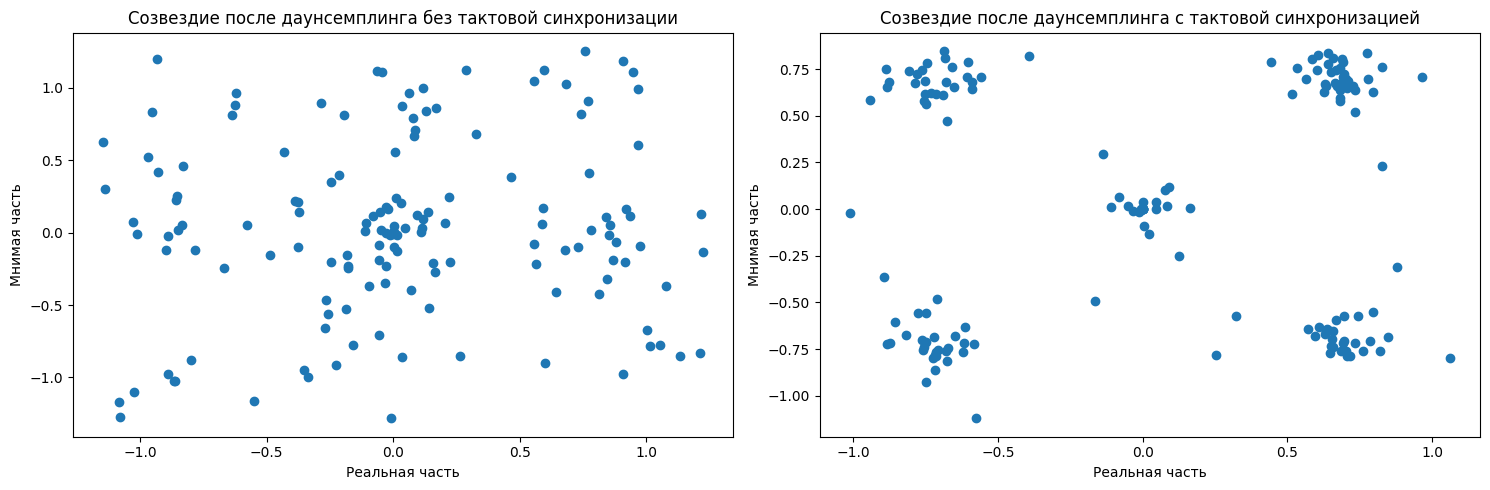

In [93]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize = (15,5))

ax1.title.set_text('Cозвездие после даунсемплинга без тактовой синхронизации')
ax1.scatter(np.real(rx_dwnsmp), np.imag(rx_dwnsmp))
ax1.set_xlabel("Реальная часть")
ax1.set_ylabel("Мнимая часть")


ax2.title.set_text('Созвездие после даунсемплинга с тактовой синхронизацией')
ax2.scatter(np.real(rx_sync_intrp), np.imag(rx_sync_intrp))
ax2.set_xlabel("Реальная часть")
ax2.set_ylabel("Мнимая часть")

plt.tight_layout()
plt.show()

Далее было принято решение посмотреть влияние величины SNR на различие данных графиков. Очевидно, что с увеличением SNR оба случая приближаются к ожидаемому созвездию, однако при наличии синхронизации это происходит значительно быстрее. Точки после фильтра в центре созвездий убираются при маппинге.

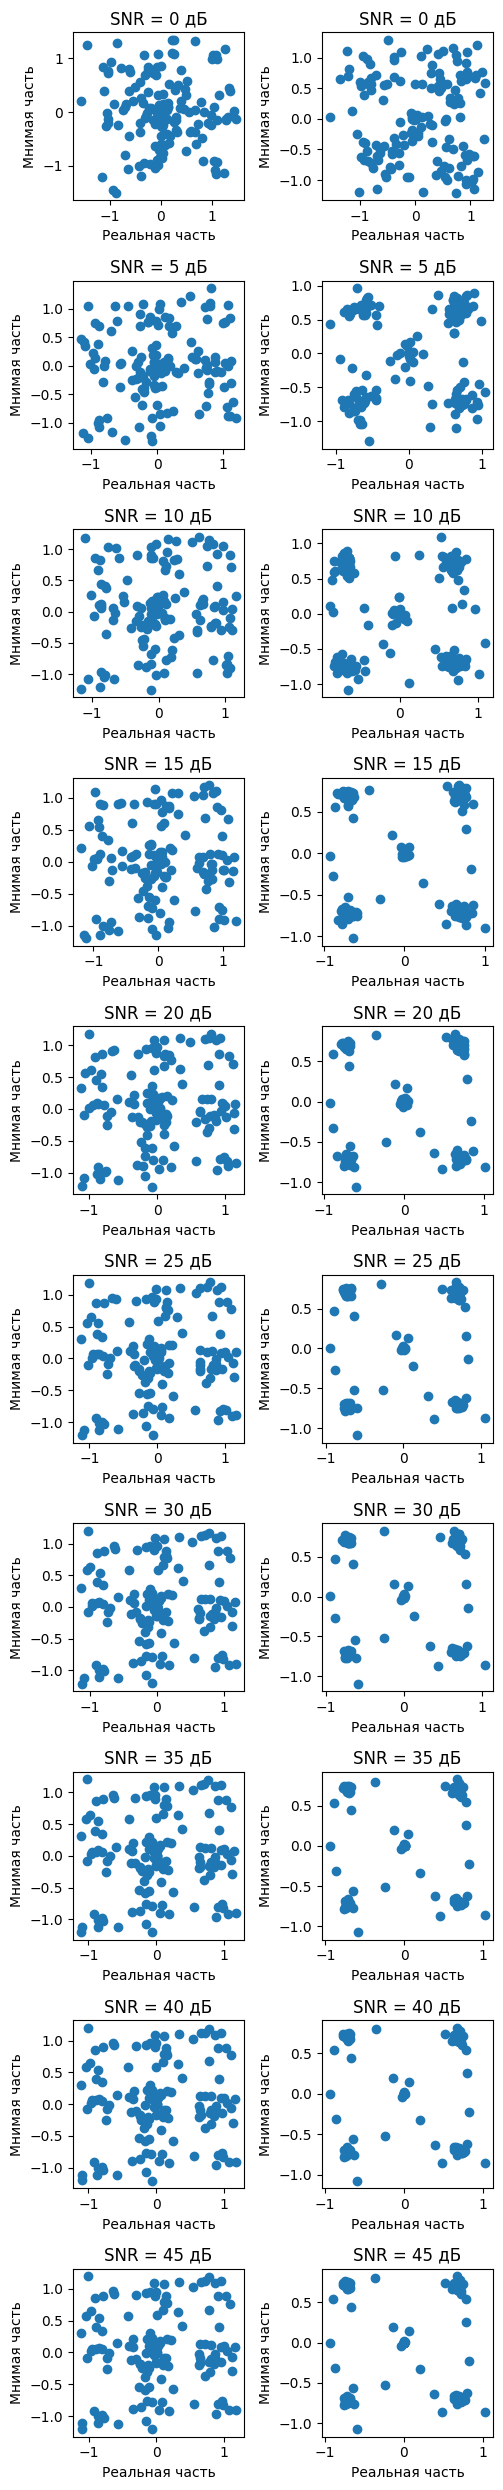

In [94]:
fig, axs = plt.subplots(10, 2, figsize=(5, 25))

for i, snr in enumerate(range(0, 50, 5)):  # используем enumerate для автоматического индекса
    awgn_noise = awgn(tx_shift, snr)
    tx_noisy = tx_shift + awgn_noise
    rx = np.convolve(tx_noisy, h_rrc)
    rx_intrp = signal.resample_poly(rx, intrp, 1)
    rx_sync_intrp = syncMM(rx, sps, rx_intrp, intrp)
    rx_dwnsmp = downsample(rx, sps)

    # Рисуем scatter plot на соответствующем subplot'е
    axs[i, 0].scatter(np.real(rx_dwnsmp), np.imag(rx_dwnsmp))
    axs[i, 0].set_title(f'SNR = {snr} дБ')
    axs[i, 0].set_ylabel("Мнимая часть")
    axs[i, 0].set_xlabel("Реальная часть")

    axs[i, 1].scatter(np.real(rx_sync_intrp), np.imag(rx_sync_intrp))
    axs[i, 1].set_title(f'SNR = {snr} дБ')
    axs[i, 1].set_ylabel("Мнимая часть")
    axs[i, 1].set_xlabel("Реальная часть")

plt.tight_layout()
plt.show()

Далее зафиксировано значение SNR равным 10 дБ и изменялась вносимая задержка. В результате для всех задержек схема с интерполяцией отработала одинаково хорошо, однако при значении 20 и выше заметны ухудшения в созвездии, причем для дробных задержек сильнее, чем для целочисленных. Таким образом, сделан вывод, что величина задержки влияет на работу схемы при значениях, приближающихся к половине длины последовательности.

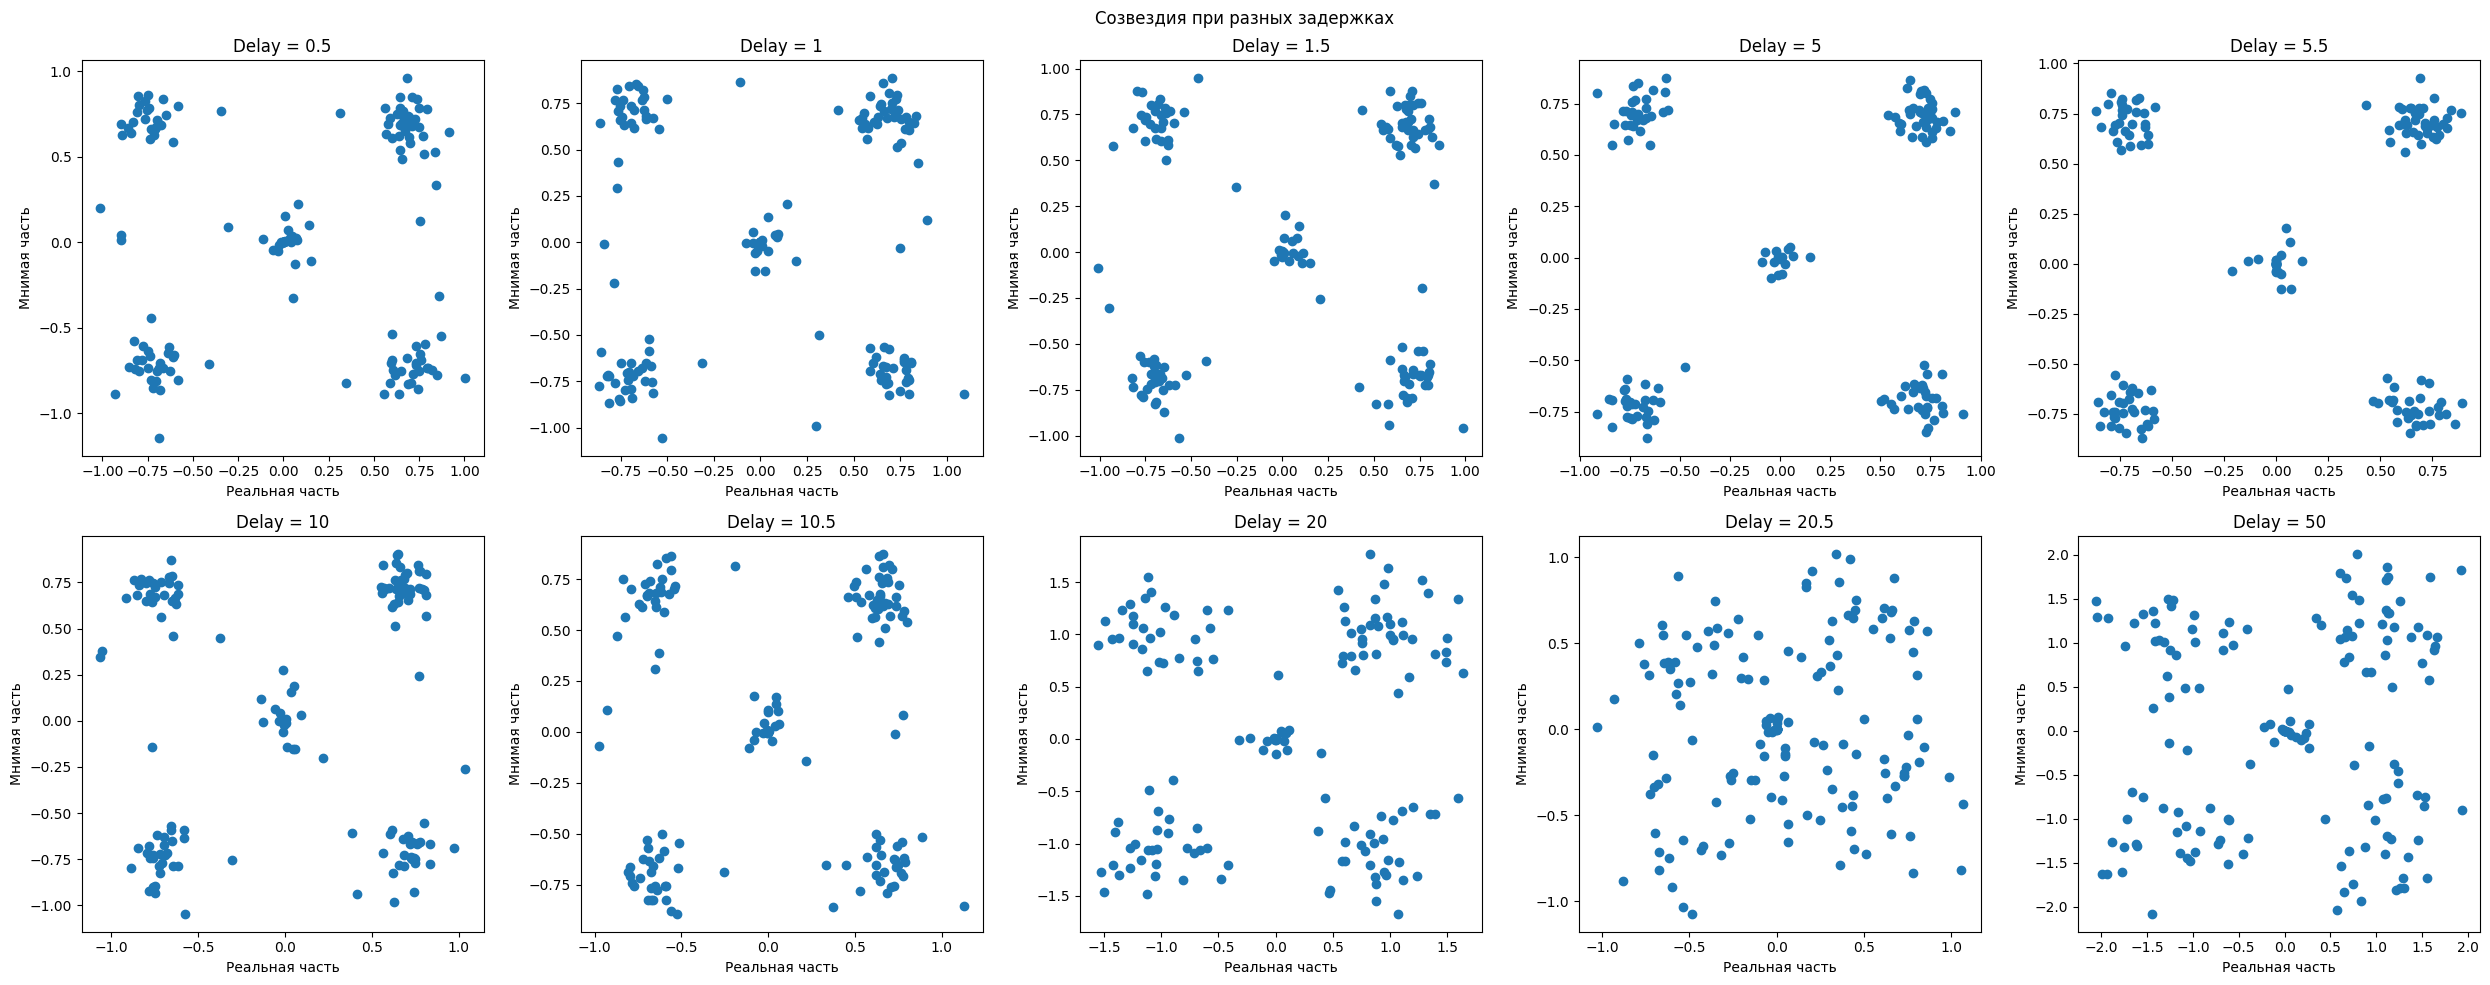

In [95]:
DELAYS = [0.5, 1, 1.5, 5, 5.5, 10, 10.5, 20, 20.5, 50]

# Лучше сделать фигуру шире для 10 столбцов
fig, axs = plt.subplots(2, 5, figsize=(25, 10))  # 2 строки, 5 столбцов
fig.suptitle('Созвездия при разных задержках')

for idx, delay in enumerate(DELAYS):
    h = np.sinc(n - delay)  # используем текущее значение задержки
    h *= np.hamming(N) 
    h /= np.sum(h) 
    tx_shift = np.convolve(tx, h)
    awgn_noise = awgn(tx_shift, 10)
    tx_noisy = tx_shift + awgn_noise
    rx = np.convolve(tx_noisy, h_rrc)
    rx_intrp = signal.resample_poly(rx, intrp, 1)
    rx_sync_intrp = syncMM(rx, sps, rx_intrp, intrp)
    
    # Определяем позицию подграфика
    row = 0 if idx < 5 else 1
    col = idx % 5
    
    # Рисуем scatter plot
    axs[row, col].scatter(np.real(rx_sync_intrp), np.imag(rx_sync_intrp))
    axs[row, col].set_title(f'Delay = {delay}')
    axs[row, col].set_ylabel("Мнимая часть")
    axs[row, col].set_xlabel("Реальная часть")

plt.tight_layout()
plt.show()

### Вывод  
В ходе выполнения лабораторной работы была реализована система для анализа схемы тактовой синхронизации. Система состояла из передающей части (генератор бит, маппер на символы, апсемплер и фильтр корня из приподнятого косинуса), канала с АБГШ и приемной части (согласованный фильтр корня из приподнятого косинуса, блок тактовой синхронизации, десемплер, интерполятор, блок принятия решений и демаппер).  
Блок тактовой синронизации был реализован с интерполятором на 8 и без и проведено сравнение результатов. Полученные созвездия и временные отображения сигналов схожи, но применение интерполяции позволяет эффективнее бороться с дробными задержками.  
Сравнение результатов работы системы после блока даунсемплинга для случаев с применением синхронизации и без при различных значениях SNR показало необходимость в применении схем тактовой синхронизации. С увеличением значений отношения сигнал/шум улучшалось результрующее созвездие, однако для схемы с тактовой синхронизацией это происходило значительно быстрее.  
Сравнение результатов работы схемы при фиксированном значении SNR и изменяющейся задержке показало зависимость: чем больше задержка, тем хуже справляется с ней схема. Однако видимые ухудшения заметны при значениях задержки приближающихся к 0,25 длины переданного сигнала и выше. Также отмечено, что при дробной задержке получены результаты хуже, чем при целочисленной.